# Indonesian NER Tagging using CRF

Install the needed library

In [ ]:
!pip install sklearn_crfsuite
!pip install seqeval

POS tagger from the previous POS tagger training

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
import sklearn_crfsuite
import pickle
nltk.download('punkt')

class POSTagger():
  def __init__(self):
    with open('model_postag', 'rb') as model:
      self.model = pickle.load(model)

  def tag(self, sent):
    if isinstance(sent, list):
      self.sent_tokenized = sent
    elif isinstance(sent, str):
      self.sent_tokenized = word_tokenize(sent)
    self.pos_tags = self.model.predict_single(self.word2features(self.sent_tokenized))
    return self.pos_tags

  def word2features(self, sent):
    feature_list = []
    for i in range(len(sent)):
      token = sent[i]
      features = {
          'token': token,
          'token.lower()': token.lower(),
          'token.istitle()': token.istitle(),
          'token.isupper()': token.isupper(),
          'token[:2]': token[:2],
          'token[:3]': token[:3],
          'token[-3:]': token[:-3],
          'token[-2:]': token[:-2],
      }
      if i > 0:
          token1 = sent[i-1]
          features.update({
              '-1:token.lower()': token1.lower(),
              '-1:token.istitle()': token1.istitle(),
              '-1:token.isupper()': token1.isupper(),
          })
      else:
          features['BOS'] = True
      if i < len(sent)-1:
          token1 = sent[i+1]
          features.update({
              '+1:token.lower()': token1.lower(),
              '+1:token.istitle()': token1.istitle(),
              '+1:token.isupper()': token1.isupper(),
          })
      else:
          features['EOS'] = True
      
      feature_list.append(features)

    return feature_list

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Import the used libraries

In [ ]:
import pandas as pd
import numpy as np
from seqeval.metrics import classification_report as entity_classification_report
from sklearn.model_selection import train_test_split
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from collections import Counter
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

Read the dataset. The dataset is from http://ner.grit.id/ but converted into CSV for easier processing

In [ ]:
data = pd.read_csv('data/ner.csv', keep_default_na=False)
data.head()

,sentence_num,token,tag
0,1,Indonesia,B-GPE
1,1,mengekspor,O
2,1,produk,O
3,1,industri,O
4,1,skala,O


List all non-O classes

In [ ]:
classes = data.tag.unique().tolist()
classes.remove('O')
classes.sort()

Show the NER tag distribution in the dataset

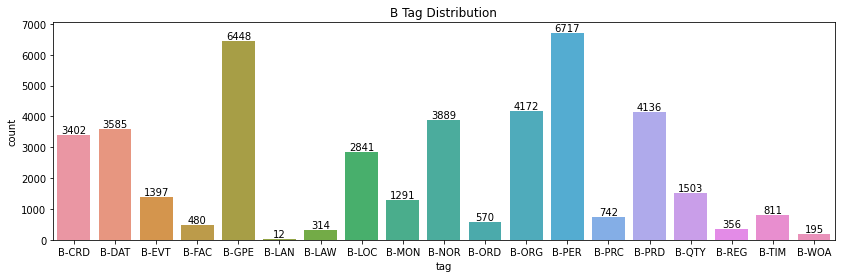

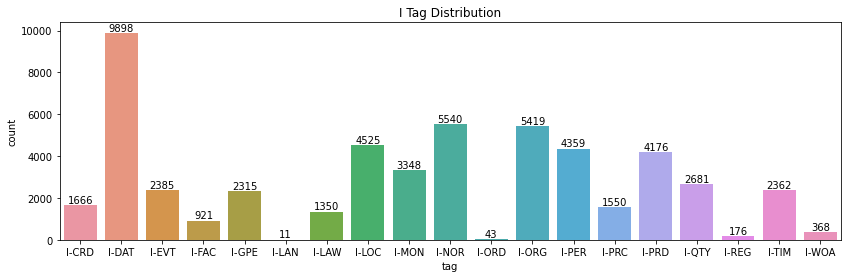

In [ ]:
plt.figure(figsize=(14, 4))
plt.title('B Tag Distribution')
ax = sns.countplot(x='tag', data=data[(data['tag'] != ' ') & (data['tag'] != 'O') & (data['tag'].str.startswith('B'))], order=[clas for clas in classes if clas[0] == 'B'])

for p in ax.patches:
  x=p.get_bbox().get_points()[:,0]
  y=p.get_bbox().get_points()[1,1]
  ax.annotate('{:d}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

plt.show()

plt.figure(figsize=(14, 4))
plt.title('I Tag Distribution')
ax = sns.countplot(x='tag', data=data[(data['tag'] != ' ') & (data['tag'] != 'O') & (data['tag'].str.startswith('I'))], order=[clas for clas in classes if clas[0] == 'I'])

for p in ax.patches:
  x=p.get_bbox().get_points()[:,0]
  y=p.get_bbox().get_points()[1,1]
  ax.annotate('{:d}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

plt.show()

Split the dataset into train and test dataset, then train the CRF model

In [ ]:
NUMERIC = ('nol', 'satu', 'dua', 'tiga', 'empat',
           'lima', 'enam', 'tujuh', 'delapan', 'sembilan')

pos_tagger = POSTagger()

def dataset_to_seq(dataset):
  tokens = dataset['token'].values.tolist()
  postags = pos_tagger.tag(tokens)
  nertags = dataset['tag'].values.tolist()
  return [(tok, p, tag) for tok, p, tag in zip(tokens, postags, nertags)]

def word2features(sent, i):
    token = sent[i][0]
    postag = sent[i][1]

    features = {
        'token.lower()': token.lower(),
        'token.istitle()': token.istitle(),
        'token.isupper()': token.isupper(),
        'token.postag()': postag,
        'token.isnumeric()': token.replace('.', '').replace('-', '').isdigit() or (token.lower() in NUMERIC),
        'token.is4digit()': len(token) == 4 and sum([1 if char.isdigit() else 0 for char in token]) == 4
    }
    if i > 0:
        token1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:token.lower()': token1.lower(),
            '-1:token.istitle()': token1.istitle(),
            '-1:token.isupper()': token1.isupper(),
            '-1:token.postag()': postag1,
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        token1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:token.lower()': token1.lower(),
            '+1:token.istitle()': token1.istitle(),
            '+1:token.isupper()': token1.isupper(),
            '+1:token.postag()': postag1,
        })
    else:
        features['EOS'] = True

    return features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]

def dataset_to_features_labels_seq(dataset):
  sentences = list(dataset.groupby('sentence_num').apply(dataset_to_seq))
  X = [sent2features(s) for s in sentences]
  y = [sent2labels(s) for s in sentences]
  return X, y

X, y = dataset_to_features_labels_seq(data)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=10)

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)
y_pred = crf.predict(X_valid)
print(metrics.flat_classification_report(y_valid, y_pred, labels=classes, digits=4))
print(entity_classification_report(y_valid, y_pred, digits=4))

              precision    recall  f1-score   support

       B-CRD     0.8472    0.9016    0.8736       732
       B-DAT     0.9691    0.9744    0.9717       741
       B-EVT     0.8154    0.6883    0.7465       308
       B-FAC     0.7917    0.6129    0.6909        93
       B-GPE     0.8885    0.9016    0.8950      1290
       B-LAN     1.0000    0.5000    0.6667         2
       B-LAW     0.7857    0.5000    0.6111        66
       B-LOC     0.8209    0.7333    0.7746       600
       B-MON     0.9518    0.9405    0.9461       252
       B-NOR     0.8502    0.8351    0.8426       843
       B-ORD     0.9057    0.8348    0.8688       115
       B-ORG     0.8090    0.7483    0.7774       866
       B-PER     0.8977    0.8888    0.8932      1412
       B-PRC     0.9714    0.9784    0.9749       139
       B-PRD     0.7861    0.6785    0.7283       818
       B-QTY     0.9004    0.7483    0.8174       302
       B-REG     0.8889    0.6234    0.7328        77
       B-TIM     0.9859    

Print only 4 numerical tags result

In [ ]:
NUM_LABELS = {'CRD', 'QTY', 'PRC', 'MON'}

y_valid_filter_num = [[label if label[2:] in NUM_LABELS else 'O' for label in sent_label] for sent_label in y_valid]
y_pred_filter_num = [[label if label[2:] in NUM_LABELS else 'O' for label in sent_label] for sent_label in y_pred]
print(metrics.flat_classification_report(y_valid_filter_num, y_pred_filter_num, digits=4))
print(entity_classification_report(y_valid_filter_num, y_pred_filter_num, digits=4))

              precision    recall  f1-score   support

       B-CRD     0.8472    0.9016    0.8736       732
       B-MON     0.9518    0.9405    0.9461       252
       B-PRC     0.9714    0.9784    0.9749       139
       B-QTY     0.9004    0.7483    0.8174       302
       I-CRD     0.8825    0.8777    0.8801       368
       I-MON     0.9799    0.9621    0.9709       659
       I-PRC     0.9933    0.9900    0.9917       301
       I-QTY     0.8981    0.8229    0.8588       525
           O     0.9971    0.9983    0.9977     53917

    accuracy                         0.9926     57195
   macro avg     0.9358    0.9133    0.9235     57195
weighted avg     0.9925    0.9926    0.9925     57195

              precision    recall  f1-score   support

         CRD     0.8280    0.8811    0.8537       732
         MON     0.9317    0.9170    0.9243       253
         PRC     0.9714    0.9784    0.9749       139
         QTY     0.8645    0.7138    0.7820       304

   micro avg     0.8668

Show what the CRF model have learnt while training

In [ ]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))
print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
9.294177 B-ORG    token.lower():detiknews
9.008235 B-MON    token.lower():lira
8.219460 B-EVT    token.lower():pilkada
8.063884 B-ORG    token.lower():detikcom
8.027147 B-MON    token.lower():rupiah
7.803718 B-REG    token.lower():muslim
7.691315 B-ORG    token.lower():genpi
7.654828 I-PRC    token.lower():persen
7.632891 B-QTY    token.lower():setahun
7.174608 B-DAT    token.lower():senin
7.038804 B-PRD    token.lower():iphone
7.016113 B-MON    token.lower():dolar
6.948667 B-PER    token.lower():jokowi
6.924178 B-NOR    token.lower():gerindra
6.904941 B-REG    token.lower():alhamdulillah
6.757737 B-NOR    token.lower():nasdem
6.668244 B-LOC    token.lower():simpanglima
6.616801 B-NOR    token.lower():golkar
6.585192 B-NOR    token.lower():demokrat
6.557220 B-PRD    token.lower():biodiesel
6.543811 B-LAW    token.lower():apbn
6.535116 B-REG    token.lower():islam
6.426624 B-NOR    token.lower():polisi
6.420687 B-TIM    -1:token.lower():jam
6.383229 B-NOR    token.lower():

Save the model into file `model_ner`

In [ ]:
with open('model_ner', 'wb') as model_out:
  pickle.dump(crf, model_out)

Train with only 4 numerical tags

In [ ]:
y_train_num = [[label if label[2:] in NUM_LABELS else 'O' for label in sent] for sent in y_train]
y_valid_num = [[label if label[2:] in NUM_LABELS else 'O' for label in sent] for sent in y_valid]

crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train_num)
y_pred_num = crf.predict(X_valid)
print(metrics.flat_classification_report(y_valid_num, y_pred_num, digits=4))
print(entity_classification_report(y_valid_num, y_pred_num, digits=4))

              precision    recall  f1-score   support

       B-CRD     0.8453    0.8811    0.8629       732
       B-MON     0.9587    0.9206    0.9393       252
       B-PRC     0.9645    0.9784    0.9714       139
       B-QTY     0.9102    0.7715    0.8351       302
       I-CRD     0.8677    0.8913    0.8794       368
       I-MON     0.9811    0.9439    0.9621       659
       I-PRC     0.9868    0.9900    0.9884       301
       I-QTY     0.8704    0.8190    0.8440       525
           O     0.9966    0.9978    0.9972     53917

    accuracy                         0.9918     57195
   macro avg     0.9313    0.9104    0.9200     57195
weighted avg     0.9917    0.9918    0.9917     57195

              precision    recall  f1-score   support

         CRD     0.8283    0.8634    0.8455       732
         MON     0.9339    0.8933    0.9131       253
         PRC     0.9645    0.9784    0.9714       139
         QTY     0.8750    0.7368    0.8000       304

   micro avg     0.8688

Show what the CRF model have learnt while training

In [ ]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))
print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Top positive:
8.726435 B-QTY    token.lower():setahun
8.046166 I-PRC    token.lower():persen
7.428893 B-MON    token.lower():usd
6.733492 B-MON    token.lower():yen
6.627586 O        -1:token.lower():persen
6.513677 O        EOS
6.099688 O        +1:token.lower():wib
6.065007 B-MON    token.lower():lira
5.740369 B-MON    token.lower():rupiah
5.737488 O        BOS
5.588437 B-MON    token.lower():euro
5.099996 O        -1:token.lower():pukul
4.889654 B-MON    token.lower():ringgit
4.801661 B-QTY    token.lower():seminggu
4.657081 B-MON    token.lower():dolar
4.549941 I-CRD    token.lower():faktur
4.531363 O        +1:token.lower():juni
4.477735 O        +1:token.lower():juli
4.386646 B-CRD    token.lower():kedelapa
4.376597 B-CRD    token.lower():berdua
4.339932 O        +1:token.lower():/
4.225045 B-QTY    token.lower():sebulan
4.151928 I-CRD    -1:token.lower():sekitar
3.998186 O        -1:token.lower():nusa
3.954118 I-CRD    token.lower():juta
3.886636 B-QTY    token.lower():semenit
3

Rule-based baseline model

In [ ]:
postag_key = 'token.postag()'
token_lower_key = 'token.lower()'

def idx_next(X, idx):
  result = idx+1
  while result+1 < len(X) and \
      (X[result][postag_key] == 'CD' or X[result][postag_key] == 'Z'):
    result += 1
  return result

def change_if_num_modifier(X, y, idx):
  modifier_list = [
                   ['sekitar'],
                   ['kurang', 'lebih'],
                   ['rata-rata'],
                   ['rata', '-', 'rata'],
                   ['lebih', 'dari'],
                   ['kurang', 'dari'],
                   ['di', 'atas'],
                   ['di', 'bawah']
  ]
  for modifier in modifier_list:
    is_match = True
    for i, modifier_token in enumerate(modifier):
      if idx + i >= len(X) or X[idx + i][token_lower_key] != modifier_token:
        is_match = False
        break

    if is_match and idx + len(modifier) < len(X) and y[idx + len(modifier)] != 'O':
      category = y[idx + len(modifier)][2:]
      y[idx] = 'B-' + category
      for i in range(1, len(modifier) + 1):
        y[idx + i] = 'I-' + category

def predict(X_seqs):
  result = []
  for X in X_seqs:
    y = []
    idx = 0
    while idx < len(X):
      next = idx_next(X, idx)
      if idx == len(X) - 1:
        y.append('O')
        idx += 1
      elif X[idx][postag_key] == 'CD' and \
          (X[next][postag_key] == 'NN' or X[next][postag_key] == 'NNP'):
        y.append('B-CRD')
        for i in range(idx+1, next):
          y.append('I-CRD')
        idx = next
      elif X[idx][postag_key] == 'SYM' and X[idx+1][postag_key] == 'CD':
        y.append('B-MON')
        for i in range(idx+1, next):
          y.append('I-MON')
        idx = next
      elif X[idx][postag_key] == 'CD' and \
          (X[next-1][token_lower_key] == 'persen' or X[next][token_lower_key] == '%'):
        y.append('B-PRC')
        for i in range(idx+1, next):
          y.append('I-PRC')
        idx = next
        if X[next][token_lower_key] == '%':
          y.append('I-PRC')
          idx = next+1
      elif X[idx][postag_key] == 'CD' and X[next][postag_key] == 'NND':
        y.append('B-QTY')
        for i in range(idx+1, next):
          y.append('I-QTY')
        y.append('I-QTY')
        idx = next+1
      else:
        y.append('O')
        idx += 1
    
    for i in range(len(X)):
      change_if_num_modifier(X, y, i)

    result.append(y)
  
  return result

y_pred_num = predict(X_valid)

print(metrics.flat_classification_report(y_valid_num, y_pred_num, digits=4))
print(entity_classification_report(y_valid_num, y_pred_num, digits=4))

              precision    recall  f1-score   support

       B-CRD     0.3139    0.6475    0.4228       732
       B-MON     0.9070    0.6190    0.7358       252
       B-PRC     0.9369    0.7482    0.8320       139
       B-QTY     0.6912    0.3113    0.4292       302
       I-CRD     0.1960    0.7147    0.3076       368
       I-MON     0.9351    0.6995    0.8003       659
       I-PRC     0.9802    0.8239    0.8953       301
       I-QTY     0.7831    0.3714    0.5039       525
           O     0.9845    0.9664    0.9753     53917

    accuracy                         0.9459     57195
   macro avg     0.7475    0.6558    0.6558     57195
weighted avg     0.9664    0.9459    0.9529     57195

              precision    recall  f1-score   support

         CRD     0.3000    0.6189    0.4041       732
         MON     0.6628    0.4506    0.5365       253
         PRC     0.9369    0.7482    0.8320       139
         QTY     0.5956    0.2664    0.3682       304

   micro avg     0.3898

## Try The Model

Create the `NERTagger` class, which we will use for NER tagging

In [ ]:
import pickle
import sklearn_crfsuite

class NERTagger():
  NUMERIC = ('nol', 'satu', 'dua', 'tiga', 'empat',
           'lima', 'enam', 'tujuh', 'delapan', 'sembilan')

  def __init__(self, pos_tagger):
    with open('model_ner', 'rb') as model:
      self.model = pickle.load(model)
    self.pos_tagger = pos_tagger

  def tag(self, sent):
    self.pos_tags = self.pos_tagger.tag(sent)
    self.sent_tokenized = self.pos_tagger.sent_tokenized
    feature_list = self.sent2features([(word, pos_tag) for word, pos_tag in zip(self.sent_tokenized, self.pos_tags)])
    predicted_tags = self.model.predict_single(feature_list)
    predicted_num_tags = [tag if tag[2:] in NUM_LABELS else 'O' for tag in predicted_tags]
    return predicted_num_tags

  def word2features(self, sent, i):
    token = sent[i][0]
    postag = sent[i][1]

    features = {
        'token.lower()': token.lower(),
        'token.istitle()': token.istitle(),
        'token.isupper()': token.isupper(),
        'token.postag()': postag,
        'token.isnumeric()': token.replace('.', '').replace('-', '').isdigit() or (token.lower() in self.NUMERIC),
        'token.is4digit()': len(token) == 4 and sum([1 if char.isdigit() else 0 for char in token]) == 4
    }
    if i > 0:
        token1 = sent[i-1][0]
        postag1 = sent[i-1][1]
        features.update({
            '-1:token.lower()': token1.lower(),
            '-1:token.istitle()': token1.istitle(),
            '-1:token.isupper()': token1.isupper(),
            '-1:token.postag()': postag1,
        })
    else:
        features['BOS'] = True
    if i < len(sent)-1:
        token1 = sent[i+1][0]
        postag1 = sent[i+1][1]
        features.update({
            '+1:token.lower()': token1.lower(),
            '+1:token.istitle()': token1.istitle(),
            '+1:token.isupper()': token1.isupper(),
            '+1:token.postag()': postag1,
        })
    else:
        features['EOS'] = True

    return features

  def sent2features(self, sent):
      return [self.word2features(sent, i) for i in range(len(sent))]

Try the model

In [ ]:
print(NERTagger(pos_tagger).tag("Tsunami Samudra Hindia merenggut sekitar 170.000 korban jiwa di Indonesia."))
print(NERTagger(pos_tagger).tag(["Tsunami", "Samudra", "Hindia", "merenggut", "sekitar", "170.000", "korban", "jiwa", "di", "Indonesia", "."]))

['O', 'O', 'O', 'O', 'B-CRD', 'I-CRD', 'O', 'O', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'B-CRD', 'I-CRD', 'O', 'O', 'O', 'O', 'O']


References:
- https://towardsdatascience.com/named-entity-recognition-and-classification-with-scikit-learn-f05372f07ba2